0.6%

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data


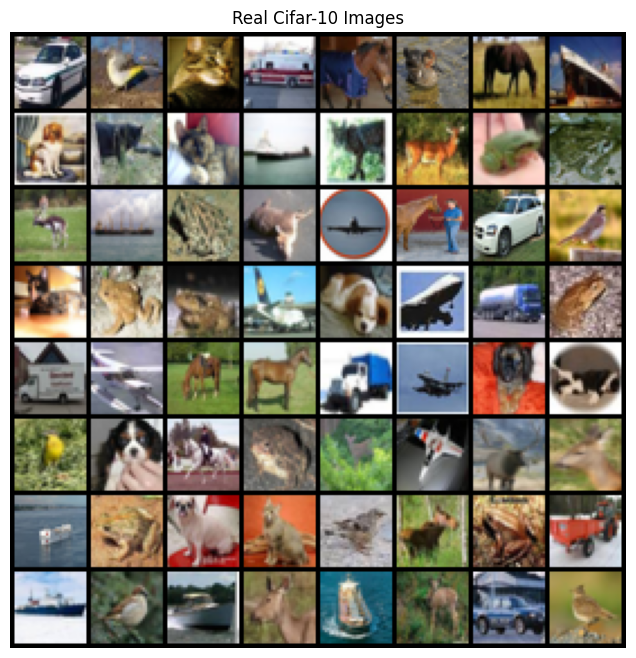

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

batchSize = 64
imageSize = 32
# Number of channels in the image
nChannels = 3
# feature space of Discriminator
nDiscFeats = 32
# number of training epochs
nEpochs = 5
# Learning rate for optimizers
lr = 0.0002

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define data transformations and normalization
transform = transforms.Compose([
  transforms.Resize(imageSize),
  transforms.CenterCrop(imageSize),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Load the CIFAR-10 dataset
real_dataset = datasets.CIFAR10(root='./data', train=True,
download=True, transform=transform)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=batchSize, shuffle=True)

# Plot some real images
real_batch = next(iter(real_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Cifar-10 Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [55]:
# https://github.com/preetum/cifar5m
fake_data = np.load("./data/cifar5m_part0.npz")
fake_targets = fake_data['Y'][0:50000]
fake_data = fake_data['X'][0:50000]

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = Image.fromarray(self.data[index])
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

fake_dataset = MyDataset(fake_data, fake_targets, transform=transform)
fake_loader = torch.utils.data.DataLoader(fake_dataset, batch_size=batchSize, shuffle=True)

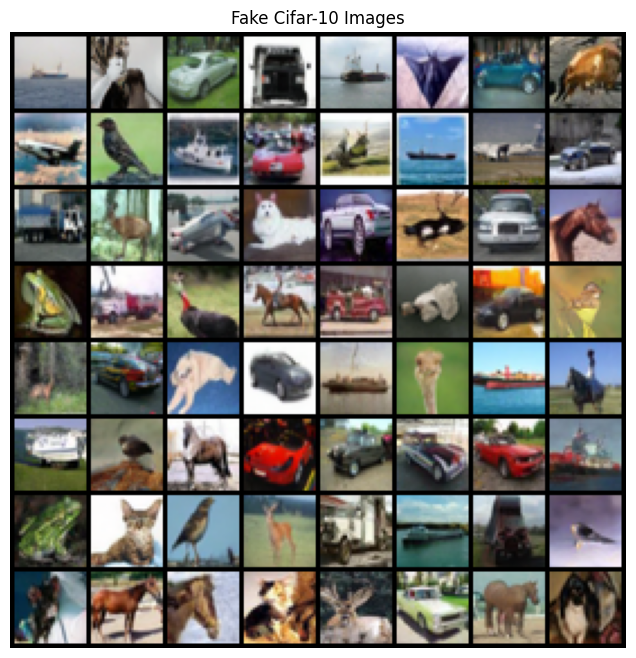

In [56]:
# Plot some fake images
fake_batch = next(iter(fake_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Cifar-10 Images")
plt.imshow(np.transpose(utils.make_grid(fake_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


Starting Training Loop...


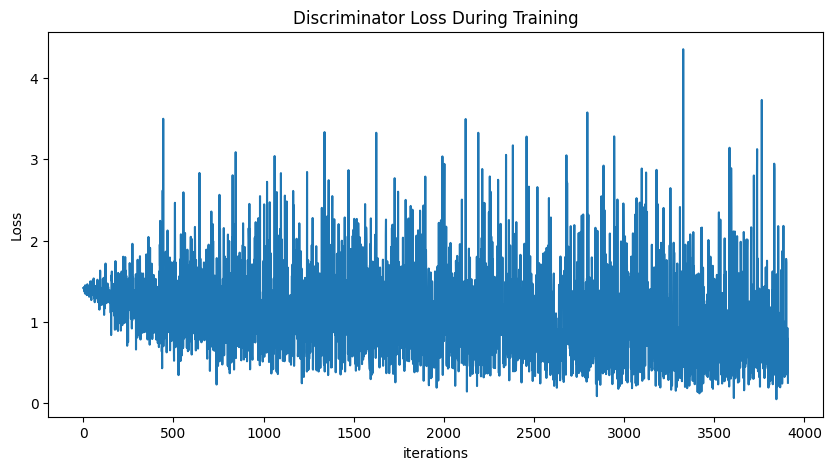

In [57]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``3 x 32 x 32``
            nn.Conv2d(nChannels, nDiscFeats, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``3 x 16 x 16``
            nn.Conv2d(nDiscFeats, nDiscFeats * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nDiscFeats * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``3 x 8 x 8``
            nn.Conv2d(nDiscFeats * 2, nDiscFeats * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nDiscFeats * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``3 x 4 x 4``
            nn.Conv2d(nDiscFeats * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

DiscModel = Discriminator().to(device)
# print(DiscModel)

# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
realLabel = 1.
fakeLabel = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(DiscModel.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(nEpochs):
    # For each batch in the dataloader
    for i, data in enumerate(zip(real_loader, fake_loader), 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        DiscModel.zero_grad()
        # Format batch
        real_cpu = data[0][0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), realLabel, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = DiscModel(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        # Format batch
        fake_cpu = data[1][0].to(device)
        label.fill_(fakeLabel)
        # Forward pass real batch through D
        output = DiscModel(fake_cpu).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        D_losses.append(errD.item())

plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()